## Selecting a deep learning model with MLP

Next step for our research is deep learning. For this stage we try using **MLP model** with keras. 

####  Import libraries,  import custom scripts and define constants  

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook


In [10]:
import tensorflow as tf
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score

import re

In [4]:
import os,sys,inspect
currentdir=os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir=os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from src import preprocessing

In [5]:
#definition constants
RANDOM_STATE = 11
TARGET_METRIC = 'f1'
TEST_SIZE = 0.15


####  Loading the data

In [6]:
# import & display data
data = pd.read_csv('../../data/IMDB_Dataset.csv')
data['sentiment'] = data['sentiment'].replace({'positive' : 1, 'negative' : 0})
data = data.drop_duplicates()
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


####  Split data for training, testing and validation sets

In [7]:
X = data.review
y = data.sentiment
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y_train)

#### Preprocessing Data

For pre-processing and vectorization, let's use the approach from the previous stage, which received the best performance.

For pre-processing:
* the removal of html-tags,
* the separation of numbers and letters.  

For vectorization we use  `TfidfVectorizer(ngram_range=(1,2))`

In [8]:
MAX_FEATURES = 50000

vectorizer = TfidfVectorizer(ngram_range=(1,2), preprocessor=preprocessing.preprocessing_text, max_features=MAX_FEATURES)

vectorizer.fit(X_train)
X_train_features = vectorizer.transform(X_train)
X_valid_features = vectorizer.transform(X_valid)
X_test_features = vectorizer.transform(X_test)

#### Creating the model

In [9]:
batch_size = 50
epochs = 30

earlystopping_callback = EarlyStopping(monitor='val_loss', patience=3)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

K.clear_session()

# Create the model
model = Sequential()
model.add(Dense(64, input_shape=(MAX_FEATURES,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

    
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


history = model.fit(X_train_features, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[earlystopping_callback, tensorboard_callback],
                    validation_data=(X_valid_features, y_valid),
                   shuffle=True,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 35822 samples, validate on 6322 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
35822/35822 [==============================] - 74s 2ms/sample - loss: 0.8674 - acc: 0.7375 - val_loss: 0.8698 - val_acc: 0.8679
Epoch 2/30
35822/35822 [==============================] - 69s 2ms/sample - loss: 0.8913 - acc: 0.8339 - val_loss: 0.8277 - val_acc: 0.8822
Epoch 3/30
35822/35822 [==============================] - 68s 2ms/sample - loss: 0.8918 - acc: 0.8458 - val_loss: 0.8430 - val_acc: 0.8814
Epoch 4/30
35822/35822 [==============================] - 69s 2ms/sample - loss: 0.8937 - acc: 0.8528 - val_loss: 0.8379 - val_acc: 0.8861
Epoch 5/30
35822/35822 [==============================] - 68s 2ms/sample - loss: 0.9024 - acc: 0.8527 - val_loss: 0.8872 - val_acc: 0.8866


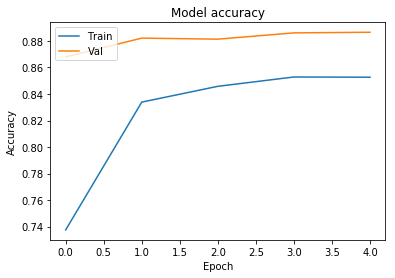

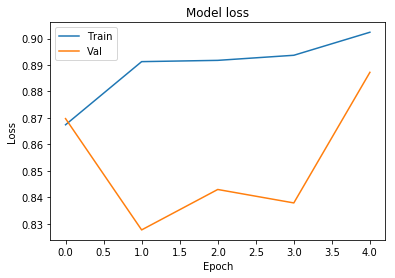

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Tuning hyperparameters for model with *Random Search*

In [39]:
X_rs = data.review
y_rs = data.sentiment
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, 
                                                    y_rs,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify = y_rs)

# Create the model
def create_model(dropout=0.1,  dense_nparams=256, optimizer='adam',
                 kernel_initializer='uniform'):
    model = Sequential()
    model.add(Dense(dense_nparams, input_shape=(MAX_FEATURES,), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nparams, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model, verbose=1)
mlp_estimator = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2), 
                                                    preprocessor=preprocessing.preprocessing_text, 
                                                    max_features=MAX_FEATURES)),  
                       ("kc", model)])

params_grid = {
    'kc__dense_nparams': [8, 16, 32, 64, 256],
    'kc__dropout': [0.5, 0.4, 0.2, 0.1, 0]
}

#search
n_iter_search = 16 # Number of parameter settings that are sampled.
random_search = RandomizedSearchCV(estimator=mlp_estimator, 
                                   param_distributions=params_grid,
                                   n_iter=n_iter_search,
                                   n_jobs=-1,  
                                   verbose=4)
random_search.fit(X_train_rs, y_train_rs)


C:\Users\Tatsiana_Drabysheusk\AppData\Local\Continuum\miniconda3\envs\Project_New\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  46 out of  48 | elapsed: 38.9min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 39.5min finished


42144/42144 [==============================] - 28s 674us/sample - loss: 0.2921 - acc: 0.8952


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 2), norm='l2',
        preprocessor=<function pre...'kc', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000227B227BA48>)]),
          fit_params=None, iid='warn', n_iter=16, n_jobs=-1,
          param_distributions={'kc__dense_nparams': [8, 16, 32, 64, 256], 'kc__dropout': [0.5, 0.4, 0.2, 0.1, 0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=4)

In [40]:
random_search.best_estimator_.steps[1][1].get_params()

{'verbose': 1,
 'dropout': 0,
 'dense_nparams': 8,
 'build_fn': <function __main__.create_model(dropout=0.1, dense_nparams=256, optimizer='adam', kernel_initializer='uniform')>}

In [41]:
random_search.best_estimator_.steps[1][1].model.get_config()

{'name': 'sequential_9',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_27',
    'trainable': True,
    'batch_input_shape': (None, 50000),
    'dtype': 'float32',
    'units': 8,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None, 'dtype': 'float32'}},
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_16',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_28',
    'trainable': True,
    'dtype': 'float32',
    'units': 8,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',


#### Apply the best model from *Random Search*

In [43]:
model_ = random_search.best_estimator_.steps[1][1].model
model_.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_.summary()

earlystopping_callback = EarlyStopping(monitor='val_loss', patience=10)


history_ = model_.fit(X_train_features, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[earlystopping_callback],
                    verbose=1,
                    validation_data=(X_valid_features, y_valid),
                   shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 8)                 400008    
_________________________________________________________________
dropout_16 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 72        
_________________________________________________________________
dropout_17 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 400,089
Trainable params: 400,089
Non-trainable params: 0
_________________________________________________________________
Train on 35822 samples, validate on 6322 samples
Epoch 1/30
35822/35822 [==============================] - 43s 1ms/sample - loss: 0.3197

In [44]:
print('F1 score for test set: ')
print(f1_score(model_.predict_classes(X_test_features), y_test))
print('F1 score for validation set: ' )
print(f1_score(model_.predict_classes(X_valid_features), y_valid))

F1 score for test set: 
0.8959785522788204
F1 score for validation set: 
0.9038944723618091


In [12]:
#function for f1 metric
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#### Apply  other model 

The result this step presents in *tensorboard.ipynb* and folder *logs/mlp/fit*

In [46]:
batch_size = 30
epochs = 30


log_dir = "logs/fit/" + 'Dense_32/64_Dropout_0.6'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

# Create the model
model = Sequential()
model.add(Dense(32, input_shape=(MAX_FEATURES,), activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', get_f1])


history = model.fit(X_train_features, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[earlystopping_callback, tensorboard_callback],
                    verbose=1,
                    validation_data=(X_valid_features, y_valid),
                   shuffle=True,)

Train on 35822 samples, validate on 6322 samples
Epoch 1/30
35822/35822 [==============================] - 44s 1ms/sample - loss: 0.3442 - acc: 0.8568 - get_f1: 0.8522 - val_loss: 0.2041 - val_acc: 0.9195 - val_get_f1: 0.9167
Epoch 2/30
35822/35822 [==============================] - 42s 1ms/sample - loss: 0.1748 - acc: 0.9365 - get_f1: 0.9350 - val_loss: 0.2078 - val_acc: 0.9217 - val_get_f1: 0.9203
Epoch 3/30
35822/35822 [==============================] - 41s 1ms/sample - loss: 0.1221 - acc: 0.9554 - get_f1: 0.9530 - val_loss: 0.2214 - val_acc: 0.9214 - val_get_f1: 0.9204
Epoch 4/30
35822/35822 [==============================] - 41s 1ms/sample - loss: 0.0894 - acc: 0.9670 - get_f1: 0.9663 - val_loss: 0.2492 - val_acc: 0.9211 - val_get_f1: 0.9188
Epoch 5/30
35822/35822 [==============================] - 41s 1ms/sample - loss: 0.0710 - acc: 0.9737 - get_f1: 0.9720 - val_loss: 0.2616 - val_acc: 0.9181 - val_get_f1: 0.9165
Epoch 6/30
35822/35822 [==============================] - 41s 1ms/

In [47]:
print('F1 score for test set: ')
print(f1_score(model.predict_classes(X_test_features), y_test))
print('F1 score for validation set: ' )
print(f1_score(model.predict_classes(X_valid_features), y_valid))

F1 score for test set: 
0.904608788853162
F1 score for validation set: 
0.9194788887144876


In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1600032   
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 1,602,209
Trainable params: 1,602,209
Non-trainable params: 0
_________________________________________________________________


### Choose the best model

In [13]:
batch_size = 30
epochs = 30

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3)
cp_callback = ModelCheckpoint(filepath='model_mlp_best.hdf5',
                              save_best_only=True,
                              verbose=1)

model_best = Sequential()
model_best.add(Dense(32, input_shape=(MAX_FEATURES,), activation='relu'))
model_best.add(Dropout(0.6))
model_best.add(Dense(1, activation='sigmoid'))


    
model_best.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', get_f1])


history = model_best.fit(X_train_features, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop, cp_callback],
                    verbose=1,
                    validation_data=(X_valid_features, y_valid),
                   shuffle=True,)


Train on 35822 samples, validate on 6322 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
35820/35822 [============================>.] - ETA: 0s - loss: 0.3713 - acc: 0.8604 - get_f1: 0.8495
Epoch 00001: val_loss improved from inf to 0.21509, saving model to model_mlp_best.hdf5
35822/35822 [==============================] - 50s 1ms/sample - loss: 0.3713 - acc: 0.8604 - get_f1: 0.8496 - val_loss: 0.2151 - val_acc: 0.9228 - val_get_f1: 0.9212
Epoch 2/30
35820/35822 [============================>.] - ETA: 0s - loss: 0.1695 - acc: 0.9432 - get_f1: 0.9419
Epoch 00002: val_loss improved from 0.21509 to 0.19244, saving model to model_mlp_best.hdf5
35822/35822 [==============================] - 51s 1ms/sample - loss: 0.1695 - acc: 0.9432 - get_f1: 0.9420 - val_loss: 0.1924 - val_acc: 0.9242 - val_get_f1: 0.9228
Epoch 3/30
35790/35822 [============================>.] - ETA: 0s - loss: 0.1044 - acc: 0.9689 - get_f1: 0.9680
Epoch 00003: val_loss did not improve from 0.19244
3582

In [14]:
print('F1 score for test set: ')
print(f1_score(model_best.predict_classes(X_test_features), y_test))
print('F1 score for validation set: ' )
print(f1_score(model_best.predict_classes(X_valid_features), y_valid))

F1 score for test set: 
0.9109333333333334
F1 score for validation set: 
0.923510971786834
